In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io.votable import parse


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Making an SED becasue that's my job

['2MASS:H' '2MASS:J' '2MASS:Ks' ':=3.6um' ':=5.8um' 'GALEX:FUV'
 'GALEX:NUV' 'Gaia:G' 'Johnson:B' 'Johnson:H' 'Johnson:J' 'Johnson:K'
 'Johnson:V' 'PAN-STARRS/PS1:y' 'PAN-STARRS/PS1:z' 'POSS-II:F' 'POSS-II:J'
 'POSS-II:i' 'SDSS:g' "SDSS:g'" 'SDSS:i' "SDSS:i'" 'SDSS:r' "SDSS:r'"
 'SDSS:u' "SDSS:u'" 'SDSS:z' "SDSS:z'" 'WISE:W1' 'WISE:W2' 'WISE:W3'
 'WISE:W4']


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in float_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


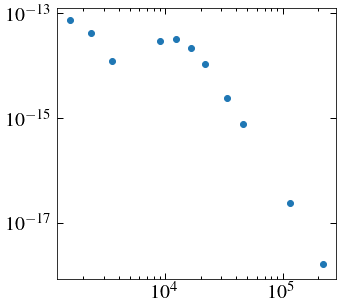

In [15]:
tphot = 'eg_uma_vizier_phot.vot'
c = 2.998e8*u.m/u.s



votable = parse(tphot)
table = votable.get_first_table()
data = table.array
mask = ~data['sed_eflux'].mask
masked_data = data[mask].data
filters = np.unique(masked_data['sed_filter'].data)
wp = []
fp = []
ep = []
print(filters)

filters = ['2MASS:H', '2MASS:J', '2MASS:Ks', 'GALEX:FUV'
 ,'GALEX:NUV', 'Gaia:G', "SDSS:g'" , "SDSS:i'" , "SDSS:r'"
 , "SDSS:u'" , "SDSS:z'" ,'WISE:W1', 'WISE:W2', 'WISE:W3',
 'WISE:W4']

for flt in filters:
    w1 = (np.mean(masked_data['sed_freq'][masked_data['sed_filter']==flt])*u.GHz).to(u.AA, equivalencies=u.spectral())
    fj1 = masked_data['sed_flux'][masked_data['sed_filter']==flt]
    e1 = masked_data['sed_eflux'][masked_data['sed_filter']==flt]
    if len(fj1) >1:
        fj_av = np.average(fj1, weights = (1/(e1**2)))
        e1_av = abs(np.average((fj1-fj_av), weights = (1/(e1**2))))**0.5
        e1_av = 1 / np.sum(1/(e1**2), axis=0)**0.5
    else:
        fj_av, e1_av = fj1[0], e1[0]
    f1 = (fj_av*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(w1)) 
    wp.append(w1.value)
    fp.append(f1.value)
    e1 = ((e1_av*f1)/fj_av).value
    ep.append(e1)

wp, fp, ep = np.array(wp), np.array(fp), np.array(ep)

plt.figure(figsize=(5, 5))
plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C0')
plt.xscale('log')
plt.yscale('log')

In [16]:
cpath = '/media/david/5tb_storage1/pceb_data/eg_uma/'
x = glob.glob('{}*x1dsum.fits'.format(cpath))[0]

smooth=5
data = fits.getdata(x, 1)
wc = np.array([], dtype=float)
fc = np.array([], dtype=float)
ec = np.array([], dtype=float)
for dt in data[::-1]:
    wi, fi, ei, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
   # mask = (fi>0) & (dq == 0) & (wi < 1213) | (wi > 1217) & (fi>0) & (dq == 0) 
    mask = (dq==0)
    wi, fi, ei = wi[mask], fi[mask], ei[mask]
    wc = np.concatenate((wc, wi))
    fc = np.concatenate((fc, fi))
    ec = np.concatenate((ec, ei))    

fc = convolve(fc,Box1DKernel(smooth))
ec = convolve(ec,Box1DKernel(smooth))/(smooth**0.5)

# plt.plot(wc, fc)

mask = (wc < 1210) | (wc > 1220) 
wc1, fc1, ec1 = wc[mask], fc[mask], ec[mask]

In [17]:
path = '/media/david/5tb_storage1/eg_uma/hst/stis/data/'
x1ds = glob.glob('{}*x1d.fits'.format(path))

data = fits.getdata(x1ds[0])[0]
ws, fs, es = data['WAVELENGTH'], data['FLUX'], data['ERROR']

In [88]:
data = Table.read('spect.V EG UMa.Gianninas.txt', format='ascii')
# wo, fo = data['wavelength']*u.AA, data['flux']*u.mJy#u.erg/u.s/u.cm**2/u.AA
wo, fo = data['wavelength']*u.AA, data['flux']*u.J/u.s/u.cm**2/u.AA

# plt.plot(wo, fo)

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


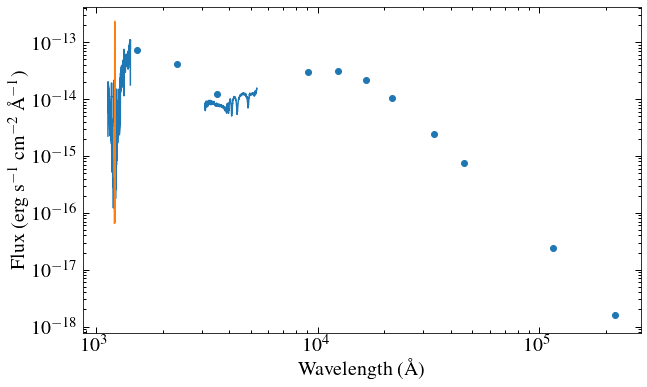

In [89]:
plt.figure(figsize=(10, 6))
mask = (wc < 1210) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0')
mask = (wc > 1220) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0', label='COS')
mask = (ws > 1210) & (ws < 1220) & (fs>0)
plt.plot(ws[mask], fs[mask], c='C1', label='STIS')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# plt.legend(frameon=True)
# plt.xlim(1140, 1420)
# plt.ylim(-0.1e-13, 1e-13)

# plt.plot([wc[0], wc[-1]], [3e-13, 3e-13], c='C1')
plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C0')

# plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wo)))
# plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA))
plt.plot(wo, fo*1e11)


plt.xscale('log')
plt.yscale('log')